# IMDB Movie review sentiment analysis

## Introduction

Given the huge volume of users review data. Sentiment Analysis has become top most priority under Natural Language Processing domain to determine the polarity of small piece of text written by the users. This project aims in finding whether the given review is either  being positive or negative.

## Description of the Data set

The dataset was obtained from [Stanford AI library](http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz). It consists of 50000 movie reviews from IMDB, and there are no more than 30 reviews per movie. The dataset consists of  equal number of positive and negative reviews. Negative reviews have scores less or equal than 4 out of 10 while a positive review have score greater or equal than 7 out of 10.

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import plotly.figure_factory as ff
import warnings
warnings.filterwarnings("ignore")

In [96]:
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec

from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE

import plotly.offline as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
import plotly.figure_factory as ff
init_notebook_mode(connected=True)
from nltk.stem import WordNetLemmatizer 
from textblob import TextBlob

In [47]:
def data_process(inpath,outpath="./",name="train_i.csv",mix=False):
    import pandas as pd
    import numpy as np
    import os
    
    
    indices=[]
    text=[]
    rating=[]
    
    i=0
    
    for filename in os.listdir(inpath+"pos"):
        data = open(inpath+"pos/"+filename, 'r' , encoding="ISO-8859-1").read()
        
        indices.append(i)
        text.append(data)
        rating.append("1")
        i = i + 1
        
    for filename in os.listdir(inpath+"neg"):
        data = open(inpath+"neg/"+filename, 'r' , encoding="ISO-8859-1").read()
        
        indices.append(i)
        text.append(data)
        rating.append("0")
        i = i + 1
        

    Dataset = list(zip(indices,text,rating))

    if mix:
        np.random.shuffle(Dataset)
    
    df = pd.DataFrame(data = Dataset, columns=['row_Number', 'text', 'polarity'])
    df.to_csv(outpath+name, index=False, header=True)

    pass


In [48]:
data_process("aclImdb/train/",outpath="./",name="train.csv",mix=False)

In [141]:
data_process("aclImdb/test/",outpath="./",name="test.csv",mix=False)

## Reading the data

In [49]:
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")

In [50]:
train.head()


,row_Number,text,polarity
0,0,For a movie that gets no respect there sure ar...,1
1,1,Bizarre horror movie filled with famous faces ...,1
2,2,"A solid, if unremarkable film. Matthau, as Ein...",1
3,3,It's a strange feeling to sit alone in a theat...,1
4,4,"You probably all already know this by now, but...",1


In [51]:
train=train.drop("row_Number",axis=1)
test=test.drop("row_Number",axis=1)

In [52]:
train.head()

,text,polarity
0,For a movie that gets no respect there sure ar...,1
1,Bizarre horror movie filled with famous faces ...,1
2,"A solid, if unremarkable film. Matthau, as Ein...",1
3,It's a strange feeling to sit alone in a theat...,1
4,"You probably all already know this by now, but...",1


In [53]:
print(train.shape)
print(test.shape)

(25000, 2)
(25000, 2)


In [54]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
text        25000 non-null object
polarity    25000 non-null int64
dtypes: int64(1), object(1)
memory usage: 390.7+ KB


### Are there any duplicates present in the dataset ?

In [55]:
train.duplicated().sum()

96

In [56]:
test.duplicated().sum()

199

There are 96 duplicates in the  train dataset and 199 duplicates in the test dataset. First we need to remove those duplicates from the data.

In [57]:
train_1=train.drop_duplicates(keep="first",inplace=False)
test_1=test.drop_duplicates(keep="first",inplace=False)

In [58]:
train_1.duplicated().sum()

0

In [59]:
test_1.duplicated().sum()

0

In [60]:
train_1.sample(10)

,text,polarity
9398,I couldn't keep from commenting after reading ...,1
15509,This entry is certainly interesting for series...,0
21023,I usually enjoy films like this. It's shot doc...,0
16789,Hello. this is my first review for any movie i...,0
13472,"Woody Allen, when at his best, has one of the ...",0
41,I have to say that this miniseries was the bes...,1
6036,"""Cry Freedom"" is not just a movie. It is a his...",1
22164,I am a big fan of Arnold Vosloo. Finally seein...,0
22729,Where oh where to begin in describing the comp...,0
20421,One can only assume that Robert Osborne is con...,0


## Feature Engineering

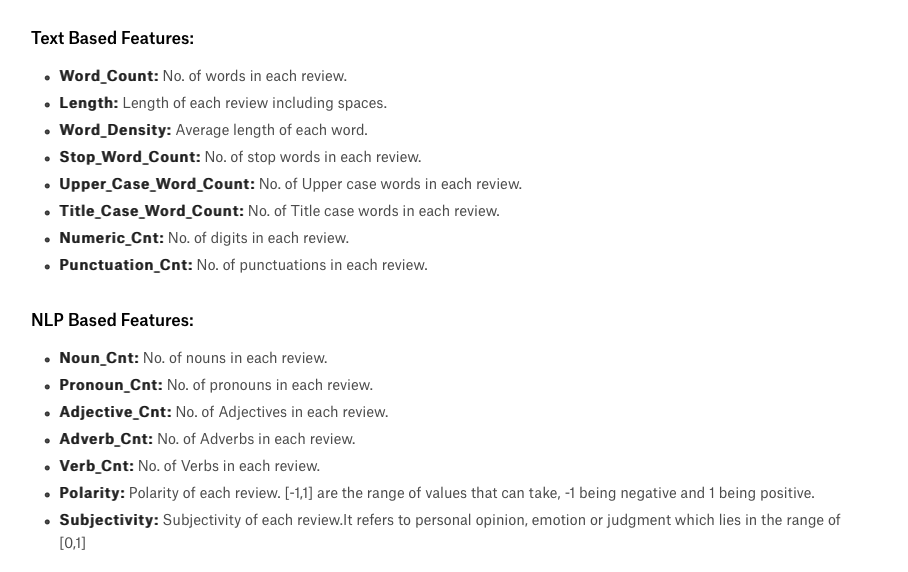


Using textblob we are obtaining subjectivity,polarity and pos tagging. Polarity is float which lies in the range of [-1,1] where 1 means positive statement and -1 means a negative statement. Subjective sentences generally refer to personal opinion, emotion or judgment whereas objective refers to factual information. Subjectivity is also a float which lies in the range of [0,1]. For more information about the text blob please go thorugh [Analytics Vidhya](https://www.analyticsvidhya.com/blog/2018/02/natural-language-processing-for-beginners-using-textblob/)

In [61]:
# defining functions for polarity, subjectivity and parts of speech counts

stop_words=stopwords.words("english")
def get_polarity(text):
    try:
        tb=TextBlob(str(text))
        polarity=tb.sentiment.polarity
    except:
        polarity=0.0
    return polarity


def get_subjectivity(text):
    try:
        tb=TextBlob(str(text))
        subjectivity=tb.sentiment.subjectivity
    except:
        subjectivity=0.0
    return subjectivity



In [62]:
# function for extracting features:

def extract_text_features(df):
    df["word_count"]=df['text'].apply(lambda x:len(str(x).split()))
    df["length"]=df['text'].apply(len)
    df["word_density"]=df["word_count"]/df["length"]
    df["stop_word_count"]=df["text"].apply(lambda x: len([word for word in str(x).split() if word in stop_words]))
    df["uppercase_wordcount"]=df["text"].apply(lambda x: len([word for word in str(x).split() if word.isupper()]))
    df["titlecase_wordcount"]=df["text"].apply(lambda x: len([word for word in str(x).split() if word.istitle()]))
    df["numeric_wordcount"]=df["text"].apply(lambda x: len([word for word in str(x).split() if word.isdigit()]))
    df["punctuation_wordcount"]=df["text"].apply(lambda x: len([word for word in str(x).split() if word in string.punctuation]))
    
    
    df["Polarity"]=df["text"].apply(lambda x:get_polarity(str(x)))
    df["Subjectivity"]=df["text"].apply(lambda x:get_subjectivity(str(x)))
    
    return df

In [63]:
train_features=extract_text_features(train_1)
test_features=extract_text_features(test_1)
train_features.to_csv("train_feat.csv")
test_features.to_csv("test_feat.csv")

In [64]:
train_featu1=pd.read_csv("train_feat.csv")
test_featu1=pd.read_csv("test_feat.csv")

In [65]:
train_featu1.head()

,Unnamed: 0,text,polarity,word_count,length,word_density,stop_word_count,uppercase_wordcount,titlecase_wordcount,numeric_wordcount,punctuation_wordcount,Polarity,Subjectivity
0,0,For a movie that gets no respect there sure ar...,1,52,284,0.183099,19,0,14,0,0,0.378125,0.947222
1,1,Bizarre horror movie filled with famous faces ...,1,166,1033,0.160697,57,0,33,0,1,0.315789,0.598246
2,2,"A solid, if unremarkable film. Matthau, as Ein...",1,55,318,0.172956,25,2,6,0,0,0.533333,0.816667
3,3,It's a strange feeling to sit alone in a theat...,1,442,2596,0.170262,163,7,63,3,0,0.075457,0.580486
4,4,"You probably all already know this by now, but...",1,144,783,0.183908,59,3,20,1,2,0.480000,0.795000


## Analysis of extracted features

In [26]:
pol1=train_featu1[train_featu1['polarity']==1]['Polarity'].values
pol0=train_featu1[train_featu1['polarity']==0]['Polarity'].values

pol_data=[pol1,pol0]
labels=["Positive","Negative"]
colors = ['#A56CC1', '#63F5EF']

fig = ff.create_distplot(pol_data, labels, colors=colors, bin_size=.05, show_rug=False)

fig.layout.margin.update({'t':50, 'l':100})
fig['layout'].update(title='Polarity Distplot')
fig.layout.template = 'plotly_dark'

py.iplot(fig, filename='Polarity')



## Summary
   * From the graph we can clearly observe that there is a clear distinguish between positive and negative reviews. Positive reviews tend to be towards 1, whereas negative reviews are tending towards 0.

In [27]:
pol_1 = train_featu1[train_featu1['polarity']==1]['Subjectivity'].values
pol_0 = train_featu1[train_featu1['polarity']==0]['Subjectivity'].values

pol_data=[pol_1,pol_0]
group_labels=['Positive','Negative']
colors = ['#A56CC1', '#63F5EF']

fig = ff.create_distplot(pol_data, group_labels, colors=colors,
                         bin_size=.05, show_rug=False)

fig['layout'].update(title='Subjectivity Distplot')
fig.layout.template = 'plotly_dark'

py.iplot(fig, filename='Subjectivity Distplot')

## Summary
 
 * From the graph we can observe that both the positive and negative review plots are overlapping with each other. Hence we can conclude that subjectivity is not able to distinguish the reviews unlike the polarity as seen in the above graph.

## Text Processing

Since the text data contains, html tags, punctuation marks, stop words, emoticons and several other non relevant data. We need to process the data in such a way that it helps in model building.

Below are the steps followed for Text Processing:
 * Converting the text to lowercase
 * Removing all the characters other than alpha numeric
 * Tokenize the sentence
 * Removing the stop words
 * Lemmatization


In [69]:
lemmatizer=WordNetLemmatizer()
stop_words.append("ar")


def pre_process(text):
    text=str(text.encode("utf-8")).lower()
    text=re.sub(r'[^a-zA-Z0-9]+'," ",text)
    text_tokens=word_tokenize(text)
    
    text_process=[]
    for word in text_tokens:
        if word not in stop_words and len(word)>1:
            text_process.append(str(lemmatizer.lemmatize(word)))
    
    text=" ".join(text_process)
    
    return text

In [70]:
train_1['text_clean']=train_1['text'].apply(pre_process)
test_1['text_clean']=test_1['text'].apply(pre_process)

In [71]:
train_1.sample(1)

,text,polarity,word_count,length,word_density,stop_word_count,uppercase_wordcount,titlecase_wordcount,numeric_wordcount,punctuation_wordcount,Polarity,Subjectivity,text_clean
17842,I want to state first that I am a Christian (a...,0,240,1308,0.183486,112,7,20,0,0,0.176641,0.505359,want state first christian work film tv indust...


In [72]:
print("Review before preprocess:",train_1['text'][1])
print("Review after preprocess:",train_1['text_clean'][1])

Review before preprocess: Bizarre horror movie filled with famous faces but stolen by Cristina Raines (later of TV's "Flamingo Road") as a pretty but somewhat unstable model with a gummy smile who is slated to pay for her attempted suicides by guarding the Gateway to Hell! The scenes with Raines modeling are very well captured, the mood music is perfect, Deborah Raffin is charming as Cristina's pal, but when Raines moves into a creepy Brooklyn Heights brownstone (inhabited by a blind priest on the top floor), things really start cooking. The neighbors, including a fantastically wicked Burgess Meredith and kinky couple Sylvia Miles & Beverly D'Angelo, are a diabolical lot, and Eli Wallach is great fun as a wily police detective. The movie is nearly a cross-pollination of "Rosemary's Baby" and "The Exorcist"--but what a combination! Based on the best-seller by Jeffrey Konvitz, "The Sentinel" is entertainingly spooky, full of shocks brought off well by director Michael Winner, who mounts 

##  Text Featurization Techniques

Since Machine can only understand numbers, we need to convert text into numbers inorder to build Machine Learning Algorithms.

Below are the few techniques used for Text Featurization
 * Bag of words
 * Term frequency-inverse document frequency
 * Word embeddings
    - Word2vec
    - TF-IDF WORD2VEC

## Bag of Words

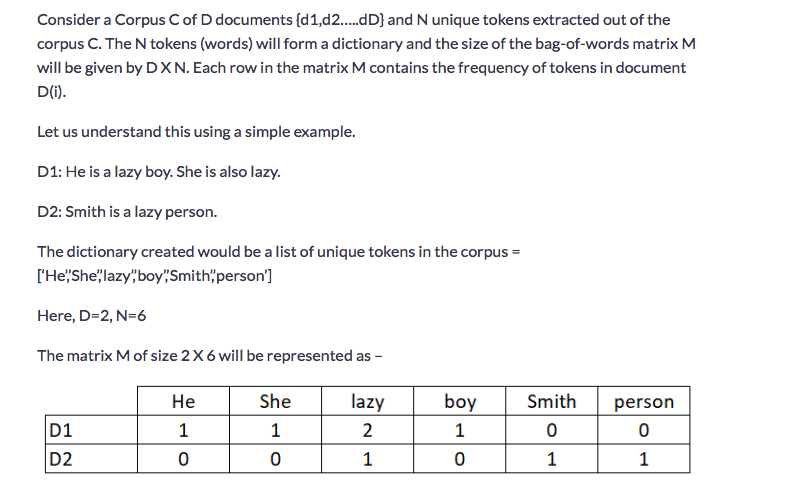

For more information please go through [Medium article]( https://medium.com/greyatom/an-introduction-to-bag-of-words-in-nlp-ac967d43b428)

In [82]:
bow=CountVectorizer(min_df=5,analyzer='word')
bow_train=bow.fit_transform(train_1['text_clean'])
bow_test=bow.transform(test_1['text_clean'])

In [85]:
print(bow_train.shape)
print("The number of unique words: ",bow_train.shape[1])

(24904, 24244)
The number of unique words:  24244


## BOW featurization with N-grams

In the above Bag-of-words model only the counts of words mattered and the order is discarded. For instance, in the example "Ram likes to watch movies. Krish likes movies too", the bag-of-words representation will not reveal that the verb "likes" always follows a person's name in this text. 

As an alternative, the n-gram model can store this spatial information.

In [87]:
bow_ngrams = CountVectorizer(min_df=5, analyzer='word', ngram_range=(1,3))
bow_train_ngrams = bow_ngrams.fit_transform(train_1['text_clean'].values)
bow_test_ngrams = bow_ngrams.transform(test_1['text_clean'].values)


In [88]:
print(bow_train_ngrams.shape)
print("The number of unique words: ",bow_train_ngrams.shape[1])

(24904, 106133)
The number of unique words:  106133


## TF-IDF Featurization


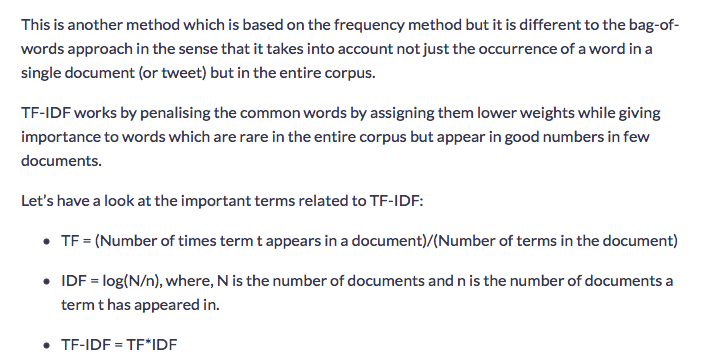

In [90]:
tfidf = TfidfVectorizer(min_df=5, analyzer='word',dtype=np.float32) 
tfidf_train = tfidf.fit_transform(train_1['text_clean'].values)
tfidf_test = tfidf.transform(test_1['text_clean'].values)


In [91]:
print("The shape of train Tf-Idf vectorizer ",tfidf_train.get_shape())
print("the number of unique words ", tfidf_train.get_shape()[1])

The shape of train Tf-Idf vectorizer  (24904, 24244)
the number of unique words  24244


## TF-IDF Featurization with N-grams

In [92]:
tfidf_ngrams = TfidfVectorizer(min_df=5, analyzer='word',ngram_range=(1,3),dtype=np.float32) 
tfidf_train_ngrams = tfidf_ngrams.fit_transform(train_1['text_clean'].values)
tfidf_test_ngrams = tfidf_ngrams.transform(test_1['text_clean'].values)

In [93]:
print("The shape of train Tf-Idf vectorizer with ngrams ",tfidf_train_ngrams.get_shape())
print("the number of unique words ", tfidf_train_ngrams.get_shape()[1])

The shape of train Tf-Idf vectorizer with ngrams  (24904, 106133)
the number of unique words  106133


## Word Embeddings (Word2vec)

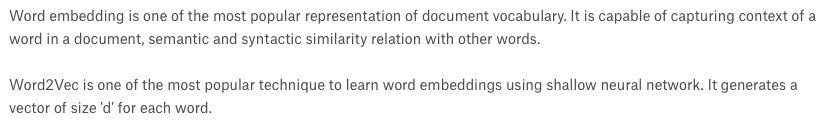

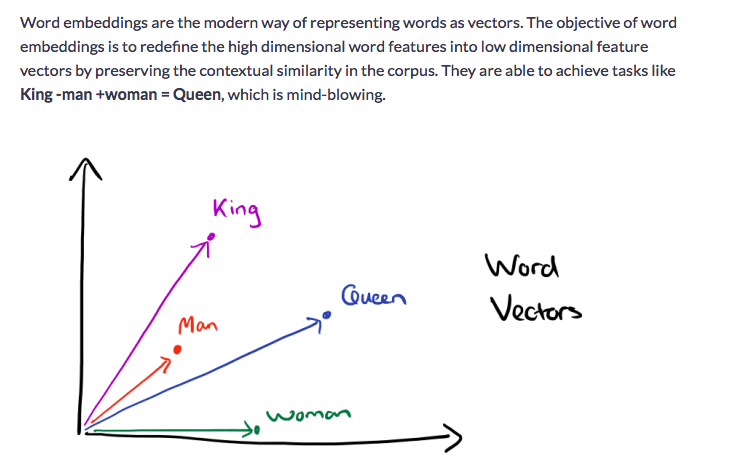

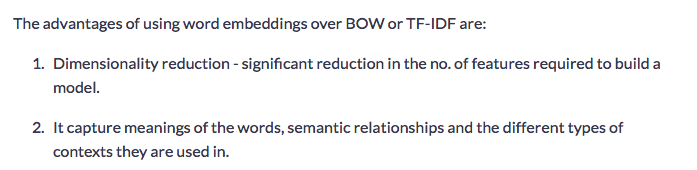

For more information please go through [Analytics Vidhya website](https://www.analyticsvidhya.com/blog/2017/06/word-embeddings-count-word2veec/)

In [94]:
list_of_sentence_train=[]
for sentence in train_1['text_clean']:
    list_of_sentence_train.append(sentence.split())
    
list_of_sentence_test=[]
for sentence in test_1['text_clean']:
    list_of_sentence_test.append(sentence.split())

In [97]:
w2v_model=Word2Vec(list_of_sentence_train, size=50, min_count=5, workers=4)
w2v_words = list(w2v_model.wv.vocab)
